In [ ]:
import pandas as pd
import numpy as np
import pickle
import sys
from sentence_transformers import SentenceTransformer
import sklearn
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import tensorflow as tf
import keras
from keras import Sequential, regularizers 

from keras.layers import Embedding, LSTM, Dense
from keras import losses
from keras.layers import Dense
from keras.layers import Flatten, InputLayer

import time
from keras.callbacks import EarlyStopping, ModelCheckpoint
import torch
from sklearn.metrics import precision_score, \
    recall_score, confusion_matrix, classification_report, \
    accuracy_score, f1_score, roc_auc_score
from sklearn.metrics import precision_recall_curve, auc
from sklearn import metrics
import plotly.express as px
from transformers import AutoTokenizer, AutoModel


In [ ]:
pip install -U sentence-transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 85 kB 1.2 MB/s 
     |████████████████████████████████| 5.8 MB 64.5 MB/s 
     |████████████████████████████████| 1.3 MB 24.7 MB/s 
     |████████████████████████████████| 182 kB 63.4 MB/s 
     |████████████████████████████████| 7.6 MB 67.3 MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125938 sha256=733b25ab56b86a5c9a88cd823ce4aaa25b2828a7773f73feb6582a6dd92f09ab
  Stored in directory: /root/.cache/pip/wheels/5e/6f/8c/d88aec621f3f542d26fac0342bef5e693335d125f4e54aeffe
Successfully built sentence-transformers


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path_df = "/content/drive/MyDrive/fake_bert/politifact_global_feature.pkl"

In [ ]:
df = pickle.load(open(path_df, "rb"))

In [ ]:
df.head()

,text,title,top_img,publish_date,images,source,target,tweet_mod,comp_text,lem_text,...,Sen15,Sen16,Sen17,Sen18,Sen19,G1,G2,G3,G4,G5
id,,,,,,,,,,,,,,,,,,,,,
politifact720,Organizing for ’18\n\nThrough Election Day\n\n...,Organizing for Action,https://secure.assets.bostatic.com/apps/quincy...,None,[https://secure.assets.bostatic.com/apps/quinc...,politifact,1,"[{'time': None, 'type': 1, 'user': 1716929114,...",Organizing for 18 Through Election Day Sometim...,organize for 18 through election day sometimes...,...,0.949437,0.034845,0.071476,1.681818,0.011628,0.012289,79.0,86.0,1.866903e-04,85.0
politifact10731,"COLUMBUS, Ohio — America's role as a world lea...",Call 'Islamic terrorism' what it is: a threat ...,http://triblive.com/csp/mediapool/sites/dt.com...,1429079762.0,[http://triblive.com/csp/mediapool/sites/TribL...,politifact,1,"[{'time': None, 'type': 1, 'user': 1716929114,...",COLUMBUS Ohio America's role as a world leader...,columbus ohio americas role a a world leader a...,...,0.694333,0.000000,-0.738400,1.250000,0.041667,0.046498,20.0,24.0,3.071834e-03,23.0
politifact11115,"In the course of the email review, State Depar...",Inquiry Sought in Hillary Clinton’s Use of Email,https://static01.nyt.com/images/2015/07/24/us/...,1437721200.0,[https://static01.nyt.com/images/2015/07/24/us...,politifact,1,"[{'time': None, 'type': 1, 'user': 1716929114,...",In the course of the email review State Depart...,in the course of the email review state depart...,...,0.778346,0.012754,-0.472698,1.156863,0.000543,0.000609,1673.0,1842.0,5.721557e-07,1841.0
politifact14148,We all get lazy from time to time and just wan...,NASA Will Pay You 18000 USD To Stay In Bed And...,http://reflectionofmind.org/wp-content/uploads...,1482942009.0,[http://reflectionofmind.org/wp-content/upload...,politifact,0,"[{'time': None, 'type': 1, 'user': 1716929114,...",We all get lazy from time to time and just wan...,we all get lazy from time to time and just wan...,...,0.829039,0.098993,0.134468,1.240000,0.000836,0.000885,1089.0,1196.0,1.024639e-06,1195.0
politifact6932,"Mitt Romney came to coal country on Aug. 14, s...",Barack Obama says Mitt Romney condemned coal-f...,http://static.politifact.com.s3.amazonaws.com/...,1345705200.0,[http://metric.politifact.com/b/ss/spttbglobal...,politifact,1,"[{'time': None, 'type': 1, 'user': 1716929114,...",Mitt Romney came to coal country on Aug. 14 st...,mitt romney come to coal country on aug 14 sta...,...,0.642184,0.016658,-0.765808,1.000000,0.025000,0.025214,38.0,40.0,6.738988e-04,39.0


In [ ]:
#Mean Pooling - Take attention mask into account for correct averaging
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0] #First element of model_output contains all token embeddings
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    sum_embeddings = tensor.sum(token_embeddings * input_mask_expanded, 1)
    sum_mask = tensor.clamp(input_mask_expanded.sum(1), min=1e-9)
    return sum_embeddings / sum_mask

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("sentence-transformers/all-MiniLM-L6-v2")
model = AutoModel.from_pretrained("sentence-transformers/all-MiniLM-L6-v2")

Downloading:   0%|          | 0.00/350 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/612 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

In [ ]:
path_to_arr = "/content/drive/MyDrive/fake_bert/politifact_micro_macro_struct_temp_linguistic_textual_graphical_sample_features.pkl"
sample_feature_array = pickle.load(open(path_to_arr, "rb"))

In [ ]:
fea_imp_df = df[['L5', 'L6', 'S6', 'Sen1', 'Sen14', 'Sen18', 'T11', 'T4', 'T5', 'T9']]

In [ ]:
fea_imp_df.head()

,L5,L6,S6,Sen1,Sen14,Sen18,T11,T4,T5,T9
id,,,,,,,,,,
politifact720,0.000000,0.000000,5.0,0.066667,0.015718,1.681818,320590416.0,320590416.0,40047.0,0.000000
politifact10731,0.000000,0.045455,3.0,0.000000,0.305667,1.250000,61189036.0,61189036.0,25224.0,0.000000
politifact11115,-0.106257,0.000000,88.0,0.000000,0.208895,1.156863,96149482.0,96149482.0,68072.0,15746.416667
politifact14148,-0.700300,0.000000,63.0,0.050000,0.072144,1.240000,70568429.0,70568429.0,389368.0,8600.227273
politifact6932,0.000000,0.055556,0.0,0.000000,0.341132,1.000000,5586406.0,5586406.0,0.0,0.000000


In [ ]:
x_train, x_test, y_train, y_test, f_train, f_test = train_test_split(df['comp_text'], df['target'], fea_imp_df, test_size= .15, random_state= 111, stratify= df['target'] )
x_train, x_val, y_train, y_val, f_train, f_val= train_test_split(x_train, y_train,f_train, test_size= .10, random_state= 111, stratify= None )

In [ ]:
f_train

,L5,L6,S6,Sen1,Sen14,Sen18,T11,T4,T5,T9
id,,,,,,,,,,
politifact15401,0.361200,0.000000,155.0,0.000000,0.010488,1.154717,18554351.0,18554351.0,53692.0,8.708880e+03
politifact12052,0.000000,0.000000,3.0,0.000000,0.000000,1.000000,207368.0,207368.0,25978.0,0.000000e+00
politifact15266,0.421500,0.000000,6.0,0.047619,0.221032,0.000000,1006129.0,109798.0,123298.0,0.000000e+00
politifact12755,0.000000,0.000000,1.0,0.000000,0.151000,0.000000,52348167.0,52348167.0,25308.0,0.000000e+00
politifact13548,0.664300,0.043478,2.0,0.043478,0.125675,1.000000,516182.0,490898.0,37377.0,0.000000e+00
...,...,...,...,...,...,...,...,...,...,...
politifact9512,0.454980,0.000000,952.0,0.000000,0.034535,1.759748,36998260.0,36869165.0,860388.0,2.579967e+04
politifact13565,-0.008486,0.000000,7.0,0.045455,0.430775,1.750000,6573188.0,6573188.0,138042.0,3.591766e+06
politifact13477,0.060617,0.050000,22.0,0.050000,0.245527,1.666667,42631291.0,42631291.0,76802.0,2.607500e+03


In [ ]:
def cls_pooling(model_output, attention_mask):
    return model_output[0][:,0]

def get_embeds(embedd):
  embed_tok = tokenizer(embedd.tolist(), padding=True, truncation=True, max_length=512, return_tensors='pt')

  with torch.no_grad():
    model_output = model(**embed_tok)

#Perform pooling. In this case, mean pooling
  # sentence_embeddings = mean_pooling(model_output, embed_tok['attention_mask'])
  # mean_pooled = model_output.sum(axis=1) / attention_mask.sum(axis=-1).unsqueeze(-1)
  sentence_embeddings = cls_pooling(model_output, embed_tok['attention_mask'])
  # tf.convert_to_tensor(sentence_embeddings, dtype='float32')
  return tf.convert_to_tensor(sentence_embeddings, dtype='float32')

In [ ]:
embed_train = get_embeds(x_train)

In [ ]:
embed_val = get_embeds(x_val)

In [ ]:
embed_test = get_embeds(x_test)

In [ ]:
scaler = preprocessing.MinMaxScaler()
f_train_transform = scaler.fit_transform(f_train)
f_val_transform = scaler.fit_transform(f_val)
f_test_transform = scaler.fit_transform(f_test)

In [ ]:
f_train

,L5,L6,S6,Sen1,Sen14,Sen18,T11,T4,T5,T9
id,,,,,,,,,,
politifact15401,0.361200,0.000000,155.0,0.000000,0.010488,1.154717,18554351.0,18554351.0,53692.0,8.708880e+03
politifact12052,0.000000,0.000000,3.0,0.000000,0.000000,1.000000,207368.0,207368.0,25978.0,0.000000e+00
politifact15266,0.421500,0.000000,6.0,0.047619,0.221032,0.000000,1006129.0,109798.0,123298.0,0.000000e+00
politifact12755,0.000000,0.000000,1.0,0.000000,0.151000,0.000000,52348167.0,52348167.0,25308.0,0.000000e+00
politifact13548,0.664300,0.043478,2.0,0.043478,0.125675,1.000000,516182.0,490898.0,37377.0,0.000000e+00
...,...,...,...,...,...,...,...,...,...,...
politifact9512,0.454980,0.000000,952.0,0.000000,0.034535,1.759748,36998260.0,36869165.0,860388.0,2.579967e+04
politifact13565,-0.008486,0.000000,7.0,0.045455,0.430775,1.750000,6573188.0,6573188.0,138042.0,3.591766e+06
politifact13477,0.060617,0.050000,22.0,0.050000,0.245527,1.666667,42631291.0,42631291.0,76802.0,2.607500e+03


In [ ]:
embedding_dim = 384
sequence_length = 512
cells = 100
batch_size= 64
epochs = 100
unique_words = 15000

In [ ]:
bertLayerModel = tf.keras.Sequential(
   [ 
    InputLayer(input_shape=(embedding_dim,)),
    InputLayer(input_shape=(57,)),
  Dense(32,activation='relu'),
  Dense(64,activation='relu'),
  Dense(32,activation='relu'),
  Dense(2,activation='sigmoid')]
)

In [ ]:
input1 = keras.layers.Input(shape=(embedding_dim, ))
input2 = keras.layers.Input(shape=(10,))
merged = keras.layers.Concatenate(axis=1)([input1, input2])

dense1 = keras.layers.Dense(64, activation=keras.activations.relu)(merged)
dense2 = keras.layers.Dense(32, activation=keras.activations.relu)(dense1)
# dense3 = keras.layers.Dense(32, activation=keras.activations.relu)(dense2)

output = keras.layers.Dense(2, activation=keras.activations.softmax)(dense2)
bertLayerModel = keras.models.Model([input1, input2], output)

In [ ]:
bertLayerModel.compile(loss='sparse_categorical_crossentropy',optimizer=tf.keras.optimizers.Adam(1e-3),metrics=['accuracy'])

In [ ]:
bertLayerModel.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 384)]        0           []                               
                                                                                                  
 input_6 (InputLayer)           [(None, 10)]         0           []                               
                                                                                                  
 concatenate_1 (Concatenate)    (None, 394)          0           ['input_5[0][0]',                
                                                                  'input_6[0][0]']                
                                                                                                  
 dense_7 (Dense)                (None, 64)           25280       ['concatenate_1[0][0]']    

In [ ]:
merged_train_arr = [embed_train, f_train_transform]
merged_val_arr = [embed_val, f_val_transform]
merged_test_arr = [embed_test, f_test_transform]

In [ ]:
embed_train.shape

TensorShape([238, 384])

In [ ]:
f_train.shape

(238, 57)

In [ ]:
earlyStopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')
mcp_save = ModelCheckpoint('.mdl_wts.hdf5', save_best_only=True, monitor='val_loss', mode='min')
start = time.time()
berthist = bertLayerModel.fit(merged_train_arr,y_train,validation_data=(merged_val_arr, y_val),
                    epochs= epochs,batch_size= batch_size, verbose=1, callbacks=[earlyStopping, mcp_save])
print(time.time()-start)

Epoch 1/100
4/4 [==============================] - 1s 77ms/step - loss: 0.7397 - accuracy: 0.5084 - val_loss: 0.6699 - val_accuracy: 0.5556
Epoch 2/100
4/4 [==============================] - 0s 15ms/step - loss: 0.6542 - accuracy: 0.6765 - val_loss: 0.6225 - val_accuracy: 0.8519
Epoch 3/100
4/4 [==============================] - 0s 15ms/step - loss: 0.6167 - accuracy: 0.7815 - val_loss: 0.5815 - val_accuracy: 0.8519
Epoch 4/100
4/4 [==============================] - 0s 15ms/step - loss: 0.5710 - accuracy: 0.8487 - val_loss: 0.5370 - val_accuracy: 0.8519
Epoch 5/100
4/4 [==============================] - 0s 16ms/step - loss: 0.5255 - accuracy: 0.8866 - val_loss: 0.4894 - val_accuracy: 0.9630
Epoch 6/100
4/4 [==============================] - 0s 15ms/step - loss: 0.4835 - accuracy: 0.8782 - val_loss: 0.4380 - val_accuracy: 0.9630
Epoch 7/100
4/4 [==============================] - 0s 14ms/step - loss: 0.4397 - accuracy: 0.8866 - val_loss: 0.3866 - val_accuracy: 0.9630
Epoch 8/100
4/4 [===

In [ ]:
file_name = "/content/drive/MyDrive/fake_bert/sbert_model_finetune"

In [ ]:
torch.save(model, file_name)

In [ ]:
bertLayerModel_pred = bertLayerModel.predict(merged_test_arr)
bertLayerModel_y = np.argmax(bertLayerModel_pred, axis = 1)
bertLayerModel_y

2/2 [==============================] - 0s 10ms/step


array([0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1,
       0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 1])

In [ ]:
bertLayerModel_pred

array([[9.9954140e-01, 4.5862453e-04],
       [8.3938497e-01, 1.6061503e-01],
       [3.8457611e-01, 6.1542380e-01],
       [1.8299911e-04, 9.9981713e-01],
       [8.8294474e-03, 9.9117053e-01],
       [9.9955189e-01, 4.4811971e-04],
       [3.6850704e-06, 9.9999624e-01],
       [8.9265603e-01, 1.0734385e-01],
       [8.0302215e-01, 1.9697772e-01],
       [9.9797285e-01, 2.0271856e-03],
       [2.8484708e-06, 9.9999708e-01],
       [9.9991089e-01, 8.9081434e-05],
       [9.9036813e-01, 9.6318461e-03],
       [4.5519787e-06, 9.9999541e-01],
       [1.2835140e-04, 9.9987173e-01],
       [9.9625021e-01, 3.7497825e-03],
       [3.2318078e-06, 9.9999672e-01],
       [1.0274150e-01, 8.9725852e-01],
       [9.9997979e-01, 2.0113594e-05],
       [8.5829782e-01, 1.4170216e-01],
       [2.0449723e-01, 7.9550272e-01],
       [1.2392262e-11, 9.9999994e-01],
       [9.9901867e-01, 9.8129339e-04],
       [9.9473405e-01, 5.2659456e-03],
       [9.9021870e-01, 9.7813122e-03],
       [2.6095444e-03, 9.

In [ ]:
print('Accuracy:', accuracy_score(bertLayerModel_y, y_test))
print('F1 score:', f1_score(y_test, bertLayerModel_y))
print('Recall:', recall_score(y_test, bertLayerModel_y))
print('Precision:', precision_score(y_test, bertLayerModel_y))
print('ROC_AUC Score:', roc_auc_score(y_test, bertLayerModel_y))
print(classification_report(y_test, bertLayerModel_y))

Accuracy: 0.7872340425531915
F1 score: 0.7727272727272727
Recall: 0.7391304347826086
Precision: 0.8095238095238095
ROC_AUC Score: 0.786231884057971
              precision    recall  f1-score   support

           0       0.77      0.83      0.80        24
           1       0.81      0.74      0.77        23

    accuracy                           0.79        47
   macro avg       0.79      0.79      0.79        47
weighted avg       0.79      0.79      0.79        47



In [ ]:
weighted_results = bertLayerModel.evaluate(tf.convert_to_tensor(embed_test, dtype='float32'), y_test,
                                           batch_size=64, verbose=0)
for name, value in zip(bertLayerModel.metrics_names, weighted_results):
  print(name, ': ', value)
print()

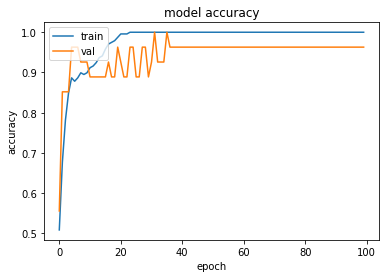

In [ ]:
from matplotlib import pyplot as plt

plt.plot(berthist.history['accuracy'])
plt.plot(berthist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

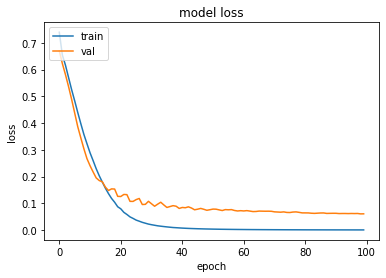

In [ ]:
from matplotlib import pyplot as plt

plt.plot(berthist.history['loss'])
plt.plot(berthist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
precision, recall, thresholds = precision_recall_curve(bertLayerModel_y, y_test)
fpr, tpr, thresholds = metrics.roc_curve(y_test, bertLayerModel_y, pos_label=1)

fig = px.area(
    x=recall, y=precision,
    title=f'Precision-Recall Curve (AUC={auc(fpr, tpr):.4f})',
    labels=dict(x='Recall', y='Precision'),
    width=700, height=500
)
fig.add_shape(
    type='line', line=dict(dash='dash'),
    x0=0, x1=1, y0=1, y1=0
)
fig.update_yaxes(scaleanchor="x", scaleratio=1)
fig.update_xaxes(constrain='domain')

fig.show()